## Public Use Microdata Sample (PUMS) - Survey Data

In [1]:
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import os
import warnings
warnings.filterwarnings("ignore")
from pandas.api.types import CategoricalDtype

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
dfa = pd.read_csv(os.path.join("csv_pus",'psam_pusa.csv'))
#dfb = pd.read_csv(os.path.join("csv_pus","psam_pusb.csv"))
#dfc = pd.read_csv(os.path.join("csv_pus","psam_pusc.csv"))
#dfd = pd.read_csv(os.path.join("csv_pus","psam_pusd.csv"))

#data = pd.concat([dfa,dfb,dfc,dfd])
data = dfa

In [3]:
print(f"Number of (rows,columns): {data.shape}")

Number of (rows,columns): (4691835, 286)


In [4]:
data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2013000000084,6,1,2600,3,1,1061971,13,19,...,14,1,1,27,24,13,14,14,13,27
1,P,2013000000154,6,1,2500,3,1,1061971,11,55,...,19,13,13,19,11,4,3,4,12,3
2,P,2013000000154,6,2,2500,3,1,1061971,13,56,...,22,13,15,23,12,4,4,5,12,4
3,P,2013000000154,6,3,2500,3,1,1061971,30,21,...,59,29,28,67,37,10,10,10,29,10
4,P,2013000000154,6,4,2500,3,1,1061971,15,21,...,28,12,14,30,13,4,4,4,17,6


In [5]:
data.columns

Index(['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'ST',
       'ADJINC', 'PWGTP', 'AGEP',
       ...
       'PWGTP71', 'PWGTP72', 'PWGTP73', 'PWGTP74', 'PWGTP75', 'PWGTP76',
       'PWGTP77', 'PWGTP78', 'PWGTP79', 'PWGTP80'],
      dtype='object', length=286)

## Filter columns

label = HINS4 (coverage through Medicaid, Medical Assistance, or any kind of government-assistance plan for those with low incomes or a disability)

In [6]:
to_collect=['AGEP','REGION','DIVISION','ST','ADJINC','COW','DEAR','MAR',
            'DDRS','DEAR','DOUT','DPHY','DRAT','INTP','SEX','RAC1P','POVPIP','PINCP']
label = ["HINS4"]

In [7]:
X = data[to_collect]
y = data[label]

In [8]:
y.replace([1.0, 2.0], [1, 0], inplace=True)


In [9]:
X.shape

(4691835, 18)

In [10]:
print(X.shape)

(4691835, 18)


## Missing Values

In [11]:
missing_values = ["n/a", "na", "--"]
print(X.isnull().sum())

AGEP              0
REGION            0
DIVISION          0
ST                0
ADJINC            0
COW         1983292
DEAR              0
MAR               0
DDRS         239404
DEAR              0
DOUT         791304
DPHY         239404
DRAT        4624413
INTP         791304
SEX               0
RAC1P             0
POVPIP       178319
PINCP        791304
dtype: int64


In [12]:
X.isin(missing_values).any()

AGEP        False
REGION      False
DIVISION    False
ST          False
ADJINC      False
COW         False
DEAR        False
MAR         False
DDRS        False
DEAR        False
DOUT        False
DPHY        False
DRAT        False
INTP        False
SEX         False
RAC1P       False
POVPIP      False
PINCP       False
dtype: bool

In [15]:
X = X.drop(['DRAT'], axis=1)

In [14]:
X = X.fillna(0.0)

In [16]:
X.head()

,AGEP,REGION,DIVISION,ST,ADJINC,COW,DEAR,MAR,DDRS,DEAR,DOUT,DPHY,INTP,SEX,RAC1P,POVPIP,PINCP
0,19,3,6,1,1061971,0.0,2,5,2.0,2,2.0,2.0,0.0,2,1,0.0,0.0
1,55,3,6,1,1061971,1.0,2,1,2.0,2,2.0,2.0,0.0,2,2,501.0,52000.0
2,56,3,6,1,1061971,6.0,2,1,2.0,2,2.0,2.0,0.0,1,2,501.0,99000.0
3,21,3,6,1,1061971,0.0,2,5,2.0,2,2.0,2.0,0.0,1,2,501.0,0.0
4,21,3,6,1,1061971,0.0,2,5,1.0,2,1.0,1.0,0.0,2,2,501.0,0.0


## Split the data - Train and Test
Splitting data into 70% training and 30% test data:

In [17]:
split_percent = 0.3
seed = 10
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=split_percent, random_state=seed)

In [18]:
print(f"X_train:{X_train.shape}, X_test: {X_test.shape}")

X_train:(3284284, 17), X_test: (1407551, 17)


## Standardizing the features

In [19]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## Computing Fairness Model


**Divide data into interest groups based on income attribute**


In [20]:
## Train data
p_1 = X_train[X_train['PINCP']<=20000] ## 20k
p_0 = X_train[X_train['PINCP']>20000]

## Test data
p_1_test = X_test[X_test['PINCP']<=20000] ## 20k
p_0_test = X_test[X_test['PINCP']>20000]

In [20]:
len(np.where(y_train.values==1)[0])

670321

### Compute threshold

In [26]:
def compute_t(fairness):
    return (1/fairness) - 1

def compute_fairness(t):
    return (1/(1+t))

In [43]:
## Consider Fairness - 0.8 - initial value
fairness = [0.7]
lambdas = [[1000,1000]]

### Compute ratio 

<p>
ratio_1 = #(p_1 & y_train ==1)/#(y_train==1) 
 </p>
 
 <p>

ratio_2 = #(p_0 & y_train ==1)/#(y_train==1)
</p>

<p>
    where p_1, p_0 are two interests groups: p_1 = income less than 20k, p_0 = income greater than 20k,
    y_train = 1 
    (HINS4 (coverage through Medicaid, Medical Assistance, or any kind of government-assistance plan for those with low incomes or a disability))
</p>

In [44]:
## Fairness matrix
# protected attribute - income
def get_ratio(p_set, y, yvalue):
    numerator = len(np.where(y.loc[p_set.index].values==yvalue)[0])
    total = len(np.where(y_train.values==yvalue)[0])
    return numerator/total


## ratio 1 and ratio 2
prior_matrix = [get_ratio(p_1,y_train,1),get_ratio(p_0,y_train,1)]
print(prior_matrix)

[0.8790609275257675, 0.1209390724742325]


#### Fairness ratio in train data:
fairness_ratio = 0.870/0.12

In [45]:
train_fairness_ratio = prior_matrix[0]/prior_matrix[1]
print(f"train fairness ratio {train_fairness_ratio}")

train fairness ratio 7.268626338382592


## a) Training Logistic Regression Model 

- test with train and test split

For Fairness,0.7 => 0.4285714285714286
C: 2.842170943040401e-14
Coefficient of each feature: [[-6.514536e-09  1.714138e-09  2.244430e-09 -2.138717e-09 -9.973527e-10
  -5.739979e-09 -9.312862e-10  8.472326e-09 -6.656211e-09 -9.312862e-10
  -1.017024e-08 -6.948231e-09 -1.782225e-09  9.018771e-10  3.413131e-09
  -1.530839e-08 -7.764977e-09]]
Training accuracy: 0.776620109588574
Test accuracy: 0.7763477131556867


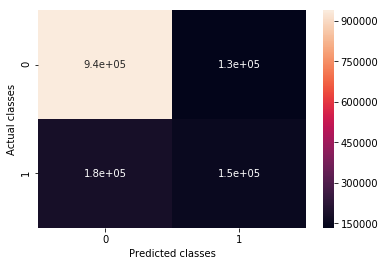

In [49]:
from sklearn.linear_model import LogisticRegression
np.set_printoptions(precision=6)


for f in fairness:
    t = compute_t(f)
    print(f"For Fairness,{f} => {t}")
    
    prior1 = (prior_matrix[0] - (1/(1+t)))
    prior2 = (prior_matrix[1] - (t/(1+t)))
    
    for (l1,l2) in lambdas:
        c = (l1*prior1 + l2*prior2)
        clf = LogisticRegression(C=c)
        
        ## Train
        clf.fit(X_train_std,y_train)
        print('C:', c)
        print('Coefficient of each feature:', clf.coef_)
        print('Training accuracy:', clf.score(X_train_std, y_train))
        
        ## Test
        y_pred = clf.predict(X_test_std)
        print('Test accuracy:', accuracy_score(y_pred, y_test.values))
        
        
        cfm = confusion_matrix(y_pred, y_test.values)
        sns.heatmap(cfm, annot=True)
        plt.xlabel('Predicted classes')
        plt.ylabel('Actual classes')
        plt.show()

        print('')

## Model Fairness on test

In [47]:
## Fairness, p_1_test, p_0_test
p_1_test_std = sc.transform(p_1_test)
p_0_test_std = sc.transform(p_0_test)


In [48]:
y_pred_p1 = clf.predict(p_1_test_std)
y_pred_p0 = clf.predict(p_0_test_std)
ratio_1 = len(np.where(y_pred_p1==1)[0])
ratio_2 = len(np.where(y_pred_p0 == 1)[0])

print(f"Test fairness: {ratio_1/ratio_2}")

Test fairness: 54.7504143188598
